# Lab 04
Antoni Zięciak (zieciak@student.agh.edu.pl)

[Paper please](https://arxiv.org/pdf/2312.06493)

## Advection-diffusion equation
This equation (which is shown below) may describe concentration $C$ of polutants in the fluid, assuming that the fluid is flowing with speed $u$ and diffusion coefficient of this polutant in that fluid is equal to $D$. 
$$\frac{\partial C}{\partial t}+u\frac{\partial C}{\partial x}-D\frac{\partial^2C}{\partial x^2}=0$$

### Analycitacal solution

Assuming that:

- $0 \leq x \leq 1$ and $t \geq 0$,
- boundary conditions: $C(0,t) = C(1,t) = 0; t \geq 0$,
- initial condition: $C(x, 0) = sin(\pi x); 0 \leq x \leq 1$,
- $D$ is constant,
- $u$ is constant,

the equation has analitical solution given by the formula:
$$C(x,t) = e^{-(\frac{u^2}{4D} + \pi^2D)t}sin(\pi x)$$

In [2]:
import numpy as np

class AnalSolution:
    def __init__(self, *, u, D):
        self.u = u
        self.D = D

    def __call__(self, x, t):
        return np.exp(-(np.square(self.u) / 4 * self.D + np.square(np.pi) * self.D) * t) * np.sin(np.pi * x)

### Numerical solution

The numerical solution to this equation could be modeled using upwind scheme from advection equation. Taking into account the fact that upwind method was created for equation $\frac{\partial C}{\partial t}=-u\frac{\partial C}{\partial x}$, as u in this scenario we can treat $u-D\frac{\partial_x C}{C}C$, which is just a sum of the $u$ for the upwind method of both diffusion and advection. That implies that the Curant number is sum of the Curant numbers of those two, so it must be calculated for each step. 

In [509]:
def F(psi_l, psi_r, C):
    return .5 * (C + abs(C)) * psi_l + \
           .5 * (C - abs(C)) * psi_r

class shift:
    def __init__(self, *, add, sub):
        self.add = add
        self.sub = sub

    def __radd__(self, o):
        return slice(o.start + self.add, o.stop + self.add)

    def __rsub__(self, o):
        return slice(o.start - self.sub, o.stop - self.sub)
    
class NumSolution:
    def __init__(self, *, t_max, u, D, nt, dx):
        self.one = shift(add=1, sub=1)
        self.hlf = shift(add=0, sub=1)

        self.u = u
        self.nt = nt
        self.dt = t_max/nt
        self.D = D
        self.dx = dx

        self.anal = AnalSolution(u=self.u, D=self.D)

    def __call__(self, x):
        initial = self.anal(x, 0)
        C = np.zeros(len(initial) - 1)

        nx = len(x)

        i = slice(1, nx-2)
        im = slice(1, nx-1)

        for j in range(self.nt):
            C[im - self.hlf] = self.dt / self.dx * (self.u - self.D * (initial[im] - initial[im-self.one]) / self.dx * 2 / (initial[im] + initial[im-self.one]))
            print(j, max(abs(C)))
            if max(abs(C)) != max(abs(C)):
                return initial
            assert max(abs(C)) <= 1 
            initial[i] = initial[i] - (F(initial[i], initial[i+self.one], C[i+self.hlf]) - F(initial[i-self.one], initial[i], C[i-self.hlf]))

        return initial

In [572]:
dx = 1/64
t_max = 5
num = NumSolution(t_max=t_max, u=2, D=3.5e-4, nt=656, dx=dx)
x = np.arange(0, 1, dx)

0 0.9799593983651652
1 0.9827865721538985
2 0.9847821969849627
3 0.9862824886189937
4 0.9874489066114772
5 0.9883798911373265
6 0.9891383628747753
7 0.9897665681695808
8 0.9902939176580607
9 0.9907415174835785
10 0.9911249024564763
11 0.9914557551623637
12 0.9917430243353432
13 0.9919936740924364
14 0.9922131987649252
15 0.9924059846077515
16 0.9925755689443256
17 0.9927248290623665
18 0.9928561220203543
19 0.9929713895207258
20 0.9930722375045316
21 0.9931599971665704
22 0.9932357721109787
23 0.9933004750179535
24 0.9933548562565173
25 0.9933995262184847
26 0.9934349726758704
27 0.99346157411901
28 0.9934796097759911
29 0.9934892668184216
30 0.9934906451049085
31 0.9934837596880337
32 0.9934685412024877
33 0.9934448341528579
34 0.9934123930218283
35 0.99337087601585
36 0.9933198361476916
37 0.9932587092140355
38 0.9931867980490936
39 0.9931032522053186
40 0.9930070419061376
41 0.9928969246993055
42 0.9927714026629975
43 0.9926286672051363
44 0.9924665273350808
45 0.992282315597268
46 

/tmp/ipykernel_4968/848091093.py:39: RuntimeWarning: invalid value encountered in divide
  C[im - self.hlf] = self.dt / self.dx * (self.u - self.D * (initial[im] - initial[im-self.one]) / self.dx * 2 / (initial[im] + initial[im-self.one]))


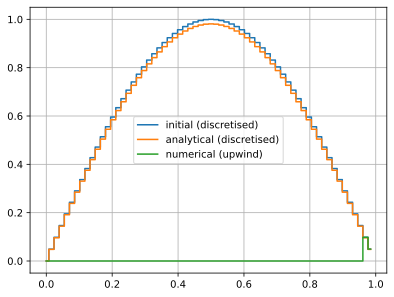

In [573]:
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot, show_anim

def plot(solution, x, t):
    fig = pyplot.figure()
    pyplot.step(x, solution.anal(x=x, t=0), label='initial (discretised)', where='mid')
    pyplot.step(x, solution.anal(x=x, t=t), label='analytical (discretised)', where='mid')
    pyplot.step(x, solution(x), label=f'numerical (upwind)', where='mid')
    pyplot.legend()
    pyplot.grid()
    return fig 
plot(num, x, t_max)
show_plot('numeric.pdf')